In [151]:
import lib
import qutip as qt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [152]:
repr(h.data).split('nnz')[-1][1:-1]

'10485760'

In [153]:
ns = [i for i in range(2, 20)]
nnzs = []
for n in ns:
    h = lib.TFIM_hamiltonian(n, 1, 0.1)
    nnzs.append(int(repr(h.data).split('nnz')[-1][1:-1]) / (2 ** (2*n)))

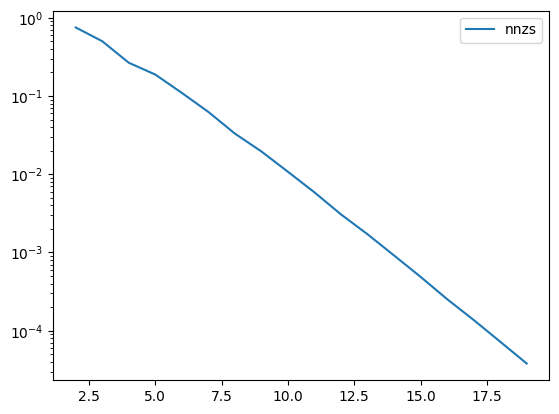

In [154]:
plt.plot(ns, nnzs, label = 'nnzs')
plt.yscale('log')
#plt.plot(ns, 2 ** np.array(ns), label = '2')
plt.legend(loc = 'best')
plt.show()

In [149]:
res = stats.linregress(ns, np.log(nnzs))

In [150]:
print(np.e ** res.slope, np.e ** res.intercept)

2.219068260323003 3.3411855828479604


In [96]:
N = 4
J = 1
Gamma = 0.1

In [97]:
h = lib.TFIM_hamiltonian(N, J, Gamma)

In [98]:
h.eigenstates()

(array([-4.01003741e+00, -4.00997512e+00, -2.82134737e-01, -2.00000000e-01,
        -2.00000000e-01, -9.97512422e-03, -6.56382816e-16, -6.51236289e-17,
        -1.23608341e-17,  2.66588687e-15,  9.97512422e-03,  2.00000000e-01,
         2.00000000e-01,  2.82134737e-01,  4.00997512e+00,  4.01003741e+00]),
 array([Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.70621299]
         [0.01772136]
         [0.01772136]
         [0.0017677 ]
         [0.01772136]
         [0.00088496]
         [0.0017677 ]
         [0.01772136]
         [0.01772136]
         [0.0017677 ]
         [0.00088496]
         [0.01772136]
         [0.0017677 ]
         [0.01772136]
         [0.01772136]
         [0.70621299]]                                                                           ,
        Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 7.06228927e-01]
  

In [99]:
h.eigenstates()[0][0]

np.float64(-4.010037405062513)

In [100]:
h.eigenstates()[1][0]

Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[0.70621299]
 [0.01772136]
 [0.01772136]
 [0.0017677 ]
 [0.01772136]
 [0.00088496]
 [0.0017677 ]
 [0.01772136]
 [0.01772136]
 [0.0017677 ]
 [0.00088496]
 [0.01772136]
 [0.0017677 ]
 [0.01772136]
 [0.01772136]
 [0.70621299]]

In [101]:
c = 1e-12
def reim(nn_output):
    return nn_output[:, 0] + 1.j * nn_output[:, 1] # Re, Im
def logamp_phase_c(nn_output):
    return (torch.exp(-nn_output[:, 0]) - c) * torch.exp(1.j * nn_output[:, 1]) 
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])

In [102]:
input = lib.generate_input_torch(N)

In [103]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)

In [104]:
vars = (N, J, Gamma)
loss_fn = lib.TFIM_expectation_from_torch
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 2)
for epoch in range(1000):
    y_pred = model(input)
    loss = loss_fn(y_pred, vars, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)

# find groud state
gs = lib.model_to_ground_state(model, input, amp_phase)

In [105]:
loss_data[-1]

-4.009988307952881

In [106]:
gs

Quantum object: dims=[[16], [1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[-2.02378124e-01-9.78033423e-01j]
 [-5.00126556e-03-2.43772268e-02j]
 [-5.08619053e-03-2.43739765e-02j]
 [-3.07032169e-04-1.56380166e-03j]
 [-5.07391011e-03-2.43635159e-02j]
 [-3.11817450e-04-1.60004443e-03j]
 [-2.98647385e-04-1.49487716e-03j]
 [-5.40509245e-05-3.05178080e-04j]
 [-5.01430221e-03-2.43767053e-02j]
 [-3.08859249e-04-1.65424589e-03j]
 [-3.01890483e-04-1.51957606e-03j]
 [-5.35611398e-05-3.08986549e-04j]
 [-3.20585823e-04-1.64165627e-03j]
 [-5.72899589e-05-3.41282517e-04j]
 [-5.54251674e-05-2.95296777e-04j]
 [-1.90335650e-05-1.18544573e-04j]]

In [107]:
flat_gs = gs.full().flatten()
superposition = flat_gs + flat_gs[::-1]

In [108]:
normalized = qt.Qobj(superposition).unit().full().flatten()
for i in normalized:
    print(abs(i))

0.7061969433319918
0.017805920492168475
0.017847920519601636
0.002309271361528386
0.01781602054774605
0.0022478268751981068
0.002267461761191237
0.01781405979068052
0.01781405979068052
0.002267461761191237
0.0022478268751981068
0.01781602054774605
0.002309271361528386
0.017847920519601636
0.017805920492168475
0.7061969433319918


In [109]:
(h.full() @ qt.Qobj(superposition).unit().full()) / qt.Qobj(superposition).unit().full()

array([[-4.01009405-3.48294998e-06j],
       [-4.00439807+7.11708526e-03j],
       [-3.99497804-4.99661273e-03j],
       [-3.08668976+3.19260248e-02j],
       [-4.00213236-3.89987267e-03j],
       [ 0.82890732+2.99635262e-02j],
       [-3.14350258+4.12498622e-02j],
       [-4.00257085+5.59748554e-03j],
       [-4.00257085+5.59748554e-03j],
       [-3.14350258+4.12498622e-02j],
       [ 0.82890732+2.99635262e-02j],
       [-4.00213236-3.89987267e-03j],
       [-3.08668976+3.19260248e-02j],
       [-3.99497804-4.99661273e-03j],
       [-4.00439807+7.11708526e-03j],
       [-4.01009405-3.48294998e-06j]])

In [110]:
h.eigenstates()

(array([-4.01003741e+00, -4.00997512e+00, -2.82134737e-01, -2.00000000e-01,
        -2.00000000e-01, -9.97512422e-03, -6.56382816e-16, -6.51236289e-17,
        -1.23608341e-17,  2.66588687e-15,  9.97512422e-03,  2.00000000e-01,
         2.00000000e-01,  2.82134737e-01,  4.00997512e+00,  4.01003741e+00]),
 array([Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.70621299]
         [0.01772136]
         [0.01772136]
         [0.0017677 ]
         [0.01772136]
         [0.00088496]
         [0.0017677 ]
         [0.01772136]
         [0.01772136]
         [0.0017677 ]
         [0.00088496]
         [0.01772136]
         [0.0017677 ]
         [0.01772136]
         [0.01772136]
         [0.70621299]]                                                                           ,
        Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 7.06228927e-01]
  

In [111]:
h.dims = [2 ** N, 2 ** N]

In [112]:
np.array(h.full())

array([[-4. +0.j, -0.1+0.j, -0.1+0.j,  0. +0.j, -0.1+0.j,  0. +0.j,
         0. +0.j,  0. +0.j, -0.1+0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [-0.1+0.j,  0. +0.j,  0. +0.j, -0.1+0.j,  0. +0.j, -0.1+0.j,
         0. +0.j,  0. +0.j,  0. +0.j, -0.1+0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [-0.1+0.j,  0. +0.j,  0. +0.j, -0.1+0.j,  0. +0.j,  0. +0.j,
        -0.1+0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.1+0.j,  0. +0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -0.1+0.j, -0.1+0.j,  0. +0.j,  0. +0.j,  0. +0.j,
         0. +0.j, -0.1+0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.1+0.j,
         0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [-0.1+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.1+0.j,
        -0.1+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
        -0.1+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -0.1+0.j,  0. +0.j,  0. +0.j, -0.1+0.j,  4. +0.j,
       

In [113]:
gs.dag().full() @ h.full() @ gs.full()

array([[-4.00998891+0.j]])

In [114]:
(h.full() @ gs.full()) / gs.full()

array([[-4.00996816+2.35230934e-07j],
       [-4.0331858 +6.54504610e-03j],
       [-4.02995372-6.91487825e-03j],
       [-3.16283239+3.09601442e-02j],
       [-4.03266234-5.35426705e-03j],
       [ 0.90679198+3.38336962e-02j],
       [-3.30577488+2.65551273e-02j],
       [-1.57049108+2.87260547e-02j],
       [-4.03283895+4.47446504e-03j],
       [-2.99634983+5.27077196e-02j],
       [ 0.74697254+2.55925813e-02j],
       [-1.57681937+2.98566526e-02j],
       [-3.01414282+3.27725657e-02j],
       [-1.47497831+3.37789406e-02j],
       [-1.61960091+1.43891651e-02j],
       [-5.05765896+1.60420541e-02j]])